In [ ]:
import os
import cv2
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
from PIL import Image
from albumentations import Compose, HorizontalFlip, Rotate, GaussianBlur, RandomBrightnessContrast, GaussNoise
from albumentations.core.composition import OneOf

In [ ]:
folder_path = 'C:/Users/Lenovo/capstone/split_dataset'
files = os.listdir(folder_path)

In [ ]:
# import tensorflow as tf
# tf.test.gpu_device_name()

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
dataset_path = '/content/drive/MyDrive/dataset'

In [ ]:
def apply_motion_blur(image, kernel_size=5):
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    return cv2.filter2D(image, -1, kernel)

def add_gaussian_noise(image):
    mean = 0
    variance = 0.001
    stddev = np.sqrt(variance)

    # Menghasilkan Gaussian noise
    gaussian_noise = np.random.normal(mean, stddev, image.shape).astype(np.float32)

    # Menambahkan noise pada gambar asli
    noisy_image = image.astype(np.float32) / 255.0 + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 1.0)  # Rentang nilai 0-1
    noisy_image = (noisy_image * 255).astype(np.uint8)  # Konversi ke rentang 0-255 dan tipe uint8

    return noisy_image


In [ ]:
def augment_images(input_dir, min_images=600, target_size=(224, 224)):
    datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            num_images = len(images)
            if num_images < min_images:
                num_to_generate = min_images - num_images
                print(f"Augmenting {num_to_generate} images for class {class_name}")

                for i in range(num_to_generate):
                    img_name = images[i % num_images]
                    img_path = os.path.join(class_path, img_name)
                    try:
                        img = cv2.imread(img_path)
                        if img is None:
                            print(f"Failed to load image: {img_path}")
                            continue

                        img = cv2.resize(img, target_size)

                        # Efek augmentasi tambahan secara acak
                        if random.choice([True, False]):
                            img = apply_motion_blur(img)
                        if random.choice([True, False]):
                            img = add_gaussian_noise(img)

                        x = keras.preprocessing.image.img_to_array(img)
                        x = x.reshape((1,) + x.shape)

                        for batch in datagen.flow(x, batch_size=1, save_to_dir=class_path, save_prefix='aug', save_format='jpg'):
                            break
                    except Exception as e:
                        print(f"Error augmenting image {img_path}: {e}")



In [ ]:
augment_images(dataset_path)

Augmenting 315 images for class durga
Augmenting 450 images for class gupolo
Augmenting 244 images for class nandhi
Augmenting 196 images for class surya
Augmenting 191 images for class candra


In [ ]:
def resize_images(input_dir, output_dir, target_size=(224, 224)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        img_resized = img.resize(target_size)
                        img_resized.save(os.path.join(output_class_path, img_name))
                except Exception as e:
                    print(f"Error resizing image {img_path}: {e}")

In [ ]:
resized_dataset_path = '/content/drive/MyDrive/resized_dataset'

In [ ]:
resize_images(dataset_path, resized_dataset_path)

In [ ]:
def split_dataset(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            train, temp = train_test_split(images, train_size=train_ratio, random_state=42)
            val, test = train_test_split(temp, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

            for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
                split_path = os.path.join(output_dir, split_name, class_name)
                if not os.path.exists(split_path):
                    os.makedirs(split_path)
                for img_name in split_data:
                    shutil.copy(os.path.join(class_path, img_name), os.path.join(split_path, img_name))

split_dataset(resized_dataset_path, '/content/drive/MyDrive/split_dataset')

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
val_test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    'C:/Users/Lenovo/capstone/split_dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    'C:/Users/Lenovo/capstone/split_dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'C:/Users/Lenovo/capstone/split_dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5206 images belonging to 10 classes.
Found 1118 images belonging to 10 classes.
Found 1120 images belonging to 10 classes.


In [ ]:
from collections import Counter
train_labels = train_generator.classes
print("Distribusi awal:", Counter(train_labels))

Distribusi awal: Counter({9: 1123, 7: 660, 4: 465, 1: 439, 0: 432, 8: 420, 2: 419, 3: 417, 6: 417, 5: 414})


In [ ]:
# Definisi model dengan perbaikan
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),

    # Block 1
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 2
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 3
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Global Average Pooling
    tf.keras.layers.GlobalAveragePooling2D(),

    # Fully Connected Layer dengan Dropout
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),

    # Output Layer
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile model dengan optimizer dan callback
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Inisialisasi callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Metode pemantauan (contohnya val_loss atau val_accuracy)
    patience=3,           # Jumlah epoch tanpa peningkatan sebelum menghentikan pelatihan
    restore_best_weights=True  # Mengembalikan bobot terbaik setelah pelatihan selesai
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 316ms/step - accuracy: 0.1911 - loss: 2.3897 - val_accuracy: 0.1145 - val_loss: 2.5144
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 315ms/step - accuracy: 0.4583 - loss: 1.7197 - val_accuracy: 0.1619 - val_loss: 2.3210
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 315ms/step - accuracy: 0.5485 - loss: 1.4756 - val_accuracy: 0.4875 - val_loss: 1.7275
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 319ms/step - accuracy: 0.6512 - loss: 1.2638 - val_accuracy: 0.7326 - val_loss: 1.2015
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.6974 - loss: 1.1273 - val_accuracy: 0.7800 - val_loss: 1.0102
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 314ms/step - accuracy: 0.7183 - loss: 1.0556 - val_accuracy: 0.8086 - val_loss: 0.9039
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 313ms/step - accuracy: 0.7496 - loss: 0.9716 - val_accuracy: 0.8372 - val_loss: 0.7901
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 316ms/step - accuracy: 0.7805 - loss: 0

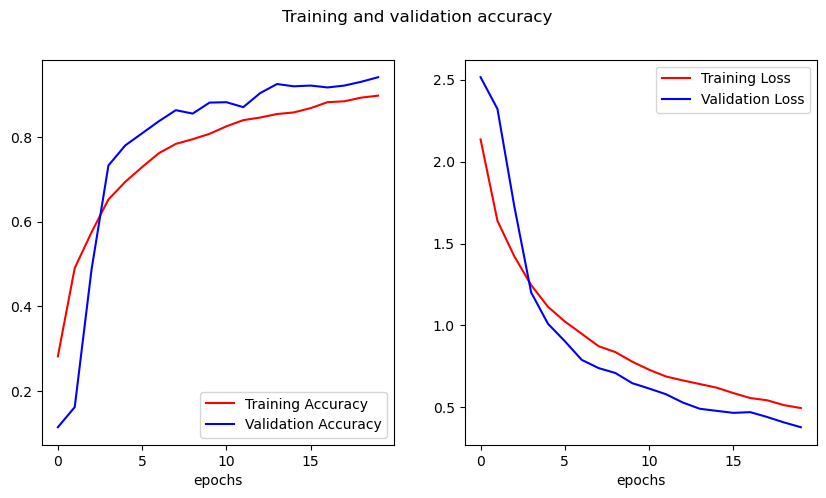

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()